In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.random.set_seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load data
- set the load data row number
- set colunms names
- remove useless colunms

In [3]:
row_num = 40000
test_num= 5500
n_time_steps = 30
n_features = 9
n_epoch = 200
batch_size=256

In [4]:
from ppl_util import DataUtil

In [5]:
path_list = ["data/DoS_dataset.csv","data/Fuzzy_dataset.csv","data/gear_dataset.csv",'data/RPM_dataset.csv',"data/normal_run_data.txt"]
data_util = DataUtil(n_row=row_num, path_list=path_list, n_time_step=n_time_steps, n_features=n_features)

In [6]:
dataset = data_util.read_files(is_shuffle=True)
dataset.head()

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,features,label
733,"[[0.5047619047619049, 0.0196078431372549, 0.16...",0
2380,"[[0.4142647777234978, 0.0196078431372549, 0.12...",1
4382,"[[0.6471990464839094, 1.0, 0.0, 0.0, 0.0, 1.0,...",3
6229,"[[0.5041716328963051, 0.0196078431372549, 0.15...",4
3789,"[[0.6376638855780691, 0.0, 0.0, 0.0, 0.0, 0.0,...",2


In [7]:
features, label = data_util.get_train_data()

In [8]:
features.shape

(6474, 30, 9)

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential

In [10]:
from tensorflow.keras.layers import Input,Conv1D,Dropout,MaxPooling1D,Flatten,Dense

In [11]:
divergence_fn = lambda q,p,_: tfd.kl_divergence(q,p)/features.shape[0]
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

In [12]:
model = Sequential([
    tfpl.Convolution1DReparameterization(
    input_shape=(n_time_steps,n_features),filters=16, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
    tfpl.Convolution1DReparameterization(
    filters=16, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
#     tfpl.Convolution1DReparameterization(
#     filters=16, kernel_size=3,activation='relu',
#     kernel_prior_fn = tfpl.default_multivariate_normal_fn,
#     kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
#     kernel_divergence_fn = divergence_fn,
#     bias_prior_fn = tfpl.default_multivariate_normal_fn,
#     bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
#     bias_divergence_fn =  divergence_fn   
#     ),
    MaxPooling1D(16),
    Flatten(),
    tfpl.DenseReparameterization(
        units = tfpl.OneHotCategorical.params_size(5),activation=None,
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn = divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn =  divergence_fn   
    ),
    tfpl.OneHotCategorical(5)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization (C (None, 28, 16)            896       
_________________________________________________________________
conv1d_reparameterization_1  (None, 26, 16)            1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense_reparameterization (De (None, 5)                 170       
_________________________________________________________________
one_hot_categorical (OneHotC multiple                  0         
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
______________________________________________________

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [13]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer='adam',
              metrics=['categorical_accuracy'],
              experimental_run_tf_function=False)

In [14]:
history = model.fit(features[:test_num], label[:test_num], epochs=n_epoch, batch_size=batch_size,
                    validation_data=(features[test_num:], label[test_num:]))

Epoch 1/200
22/22 [==============================] - 3s 19ms/step - loss: 2.1287 - categorical_accuracy: 0.2069 - val_loss: 2.1175 - val_categorical_accuracy: 0.1858
Epoch 2/200
22/22 [==============================] - 0s 4ms/step - loss: 2.1123 - categorical_accuracy: 0.2058 - val_loss: 2.0996 - val_categorical_accuracy: 0.2197
Epoch 3/200
22/22 [==============================] - 0s 4ms/step - loss: 2.0920 - categorical_accuracy: 0.1993 - val_loss: 2.0764 - val_categorical_accuracy: 0.1756
Epoch 4/200
22/22 [==============================] - 0s 5ms/step - loss: 2.0595 - categorical_accuracy: 0.2142 - val_loss: 2.0196 - val_categorical_accuracy: 0.2556
Epoch 5/200
22/22 [==============================] - 0s 6ms/step - loss: 2.0164 - categorical_accuracy: 0.2213 - val_loss: 1.9683 - val_categorical_accuracy: 0.2433
Epoch 6/200
22/22 [==============================] - 0s 6ms/step - loss: 1.9627 - categorical_accuracy: 0.2498 - val_loss: 1.9091 - val_categorical_accuracy: 0.2752
Epoch 7/2

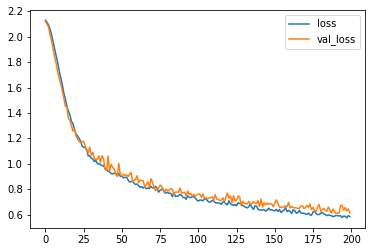

In [15]:
x = list(range(n_epoch))
plt.plot(x, history.history['loss'],label="loss")
plt.plot(x, history.history['val_loss'],label="val_loss")
plt.legend();

In [16]:
np.argmax(label[1])

1

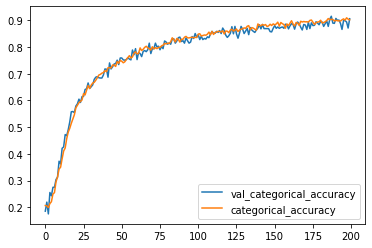

In [17]:
plt.plot(x, history.history['val_categorical_accuracy'],label="val_categorical_accuracy")
plt.plot(x, history.history['categorical_accuracy'],label="categorical_accuracy")
plt.legend();

In [18]:
x_test = features[test_num:]
y_test = dataset.label.to_list()

In [145]:
import seaborn as sns
sns.set_theme(style="white")

In [146]:
label_list = ['DoS', 'Fuzzy', 'RPM', 'gear',  'Normal']

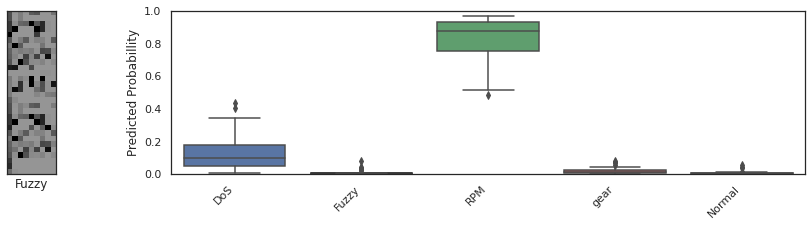

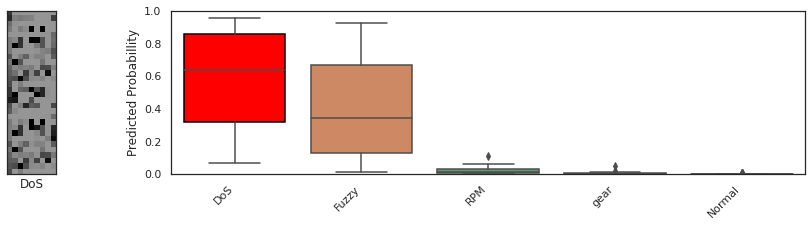

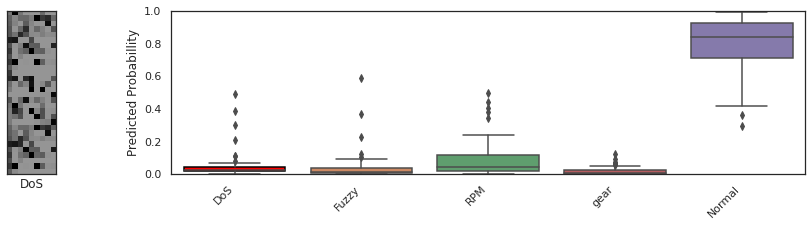

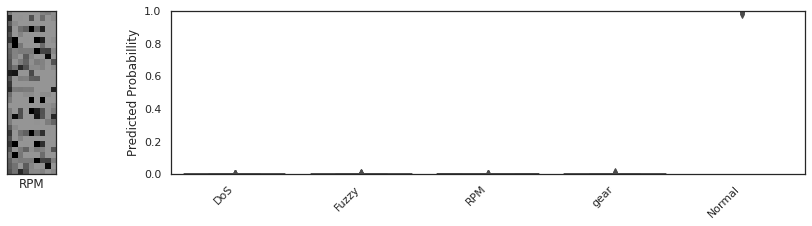

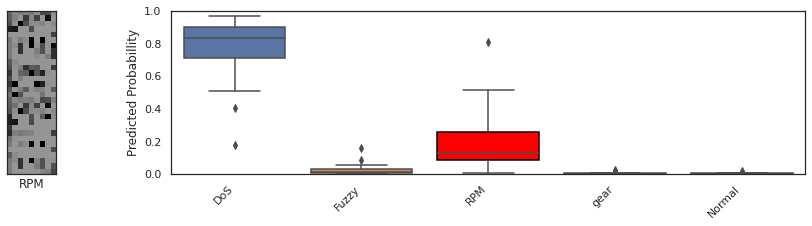

In [259]:
def plot_pred_dist(act_num,n_samples=50):
    label = data_util.label_to_activity[y_test[act_num]]
    fig, axes = plt.subplots(1,2,figsize=(15,3),gridspec_kw={'width_ratios': [1, 5]})
    axes[0].imshow(x_test[act_num], cmap='Greys', vmin=-1, vmax=1)
#     ax.axis('off')
    axes[0].axes.yaxis.set_ticks([])
    axes[0].axes.xaxis.set_ticks([])
    axes[0].set_xlabel(label)
#     plt.show()

  
    pred_prob = np.empty(shape=(n_samples, 5))
    for i in range(n_samples):
        pred_prob[i] = model(x_test[act_num][np.newaxis, ...]).mean().numpy()[0]
#     plt.figure(figsize=(10,3))
    axes[1] = sns.boxplot(data=pred_prob)
    
    mybox = axes[1].artists[y_test[act_num]]

    # Change the appearance of that box
    mybox.set_facecolor('red')
    mybox.set_edgecolor('black')


    axes[1].set_xticks(np.arange(5))
    axes[1].set_xticklabels(label_list,rotation=45, horizontalalignment='right')
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('Predicted Probabillity')
    plt.show();
for i in [1,10,250,600,650]:
    plot_pred_dist(i)

In [51]:
def analyse_model_predictions(action_num):
    
    # Show the accelerometer data
    print('------------------------------')
    print('Attack data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[action_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('Attack Event:', data_util.label_to_activity[y_test[action_num]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 5))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[action_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')

    
    bar[y_test[action_num]].set_color('blue')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(label_list,rotation=45, horizontalalignment='right')
    

    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Attack data:


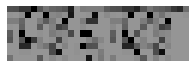

------------------------------
Attack Event: Fuzzy

------------------------------
Model estimated probabilities:


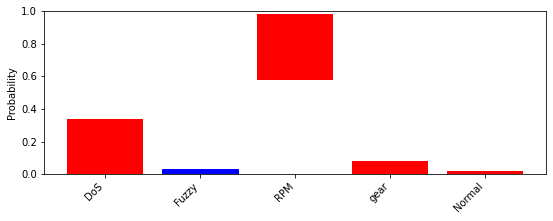

------------------------------
Attack data:


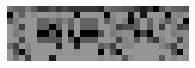

------------------------------
Attack Event: DoS

------------------------------
Model estimated probabilities:


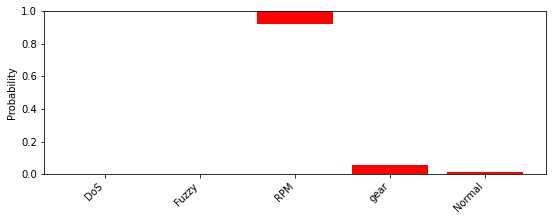

------------------------------
Attack data:


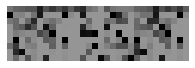

------------------------------
Attack Event: DoS

------------------------------
Model estimated probabilities:


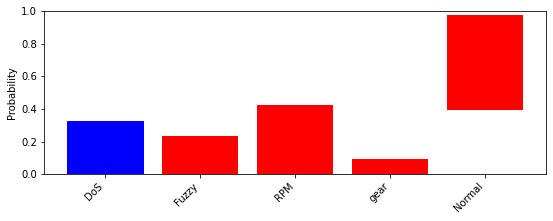

------------------------------
Attack data:


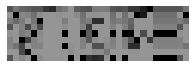

------------------------------
Attack Event: Normal

------------------------------
Model estimated probabilities:


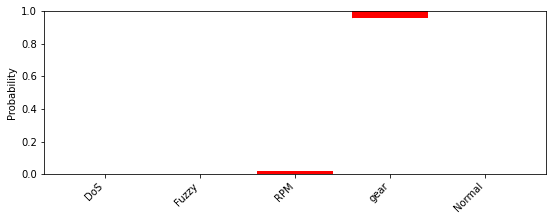

------------------------------
Attack data:


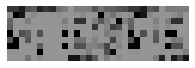

------------------------------
Attack Event: DoS

------------------------------
Model estimated probabilities:


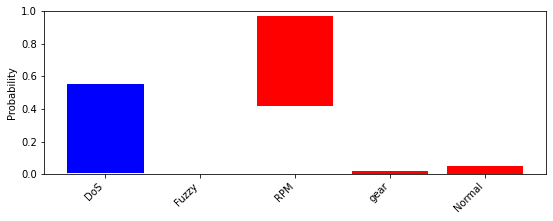

In [27]:
for i in [1,100,250,12,50]:
    analyse_model_predictions(i)

In [214]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [247]:
pred_prob = model(x_test[1][np.newaxis, ...])

In [248]:
cov = pred_prob.covariance().numpy()[0]

In [249]:
mu = pred_prob.mean()[0]

In [250]:
sigma = cov.diagonal()

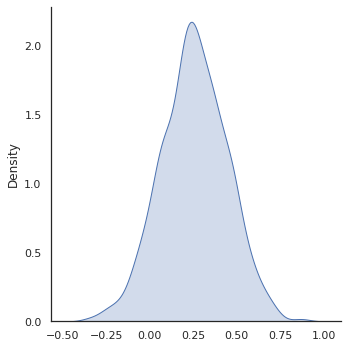

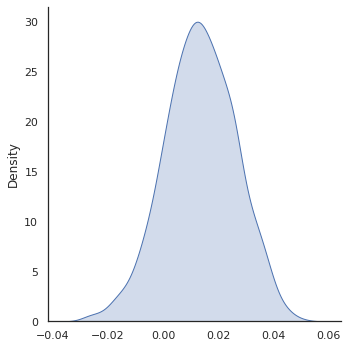

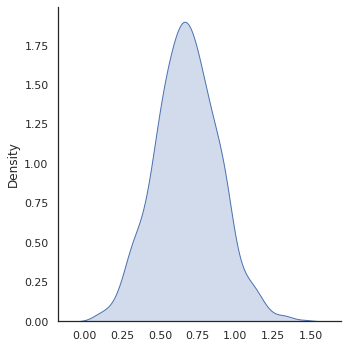

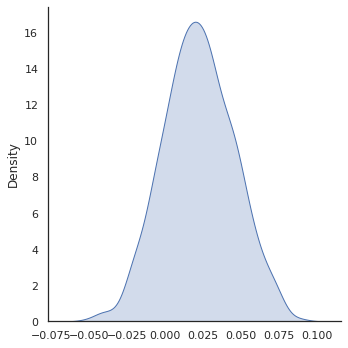

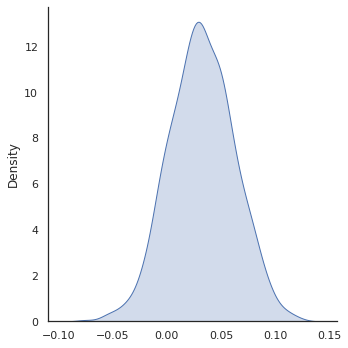

In [257]:
for i in range(5):
    dist = np.random.normal(mu[i], sigma[i], 1000)
    sns.displot(dist,kind="kde", fill=True)

In [269]:
def plot_pred_dist(act_num,n_samples=500):
  
    pred_prob = np.empty(shape=(n_samples, 5))
    for i in range(n_samples):
        pred_prob[i] = model(x_test[act_num][np.newaxis, ...]).mean().numpy()[0]
    df =  pd.DataFrame(data=pred_prob)
    df.columns = label_list
#     sns.displot(df, kind="kde")
#     g.map_lower(sns.kdeplot, levels=4, color=".2")
    return df 
     

df = plot_pred_dist(50)

In [270]:
df.head()

,DoS,Fuzzy,RPM,gear,Normal
0,0.134061,0.000251,0.861668,0.001661,0.002359
1,0.122108,0.000069,0.875827,0.000411,0.001585
2,0.294826,0.000473,0.698255,0.005717,0.000729
3,0.054615,0.000173,0.939864,0.001768,0.003579
4,0.316414,0.001184,0.668640,0.005053,0.008709


In [271]:
df.shape

(500, 5)

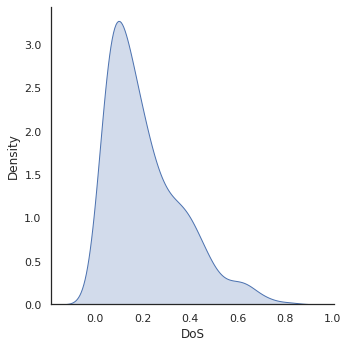

In [272]:
sns.displot(df['DoS'],kind='kde', fill=True)